#### COMP90042 2023 Project: Automated Fact Checking For Climate Science Claims

The goal of this project is to design and implement a system that takes a given `claim` (which is a single sentence) and then retrieves (one or more) `evidence passages` (each passage is also a single sentence) from a document store, then using these evidence passages classifies the claim as one of these four labels: `[SUPPORTS, REFUTES, NOT_ENOUGH_INFO, DISPUTED]`.  

Our training data consists of a document store which is a set of $D$ evidence passages `{evidence-1, evidence-2, ..., evidence-D}` and training and validation data instances where each instance is a tuple of the form `(claim_text, claim_label, evidence_list)`, where evidence list is a subset of passages from the document store.

In this notebook, we explore the use of `BM25` for passage retreival and evaluate it's performance on the project dataset. Evaluation will involve comparing retreived evidence passages for each data instance with the ground truth evidence list  and computing precision, recall and F1 score. Then we will use the `average F1 score` across all data instances as the final evaluation metric.

In [34]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict
from unidecode import unidecode
import math, random
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

#### Below is my implementation of a simple BM25 retreival system. Will later replace this with the PyLucene implementation.

In [36]:
class IR_System():
    def __init__(self, k = 1.25, b = 0.75, remove_stopwords=False, apply_stemming=False):
        self.k = k
        self.b = b
        self.remove_stopwords = remove_stopwords
        self.apply_stemming = apply_stemming
        self.tokenizer = RegexpTokenizer(r'\w+') 
        if remove_stopwords:
            self.stopwords = stopwords.words('english')
        if apply_stemming:
            self.stemmer = PorterStemmer()      

    def train(self, documents):
        self.documents = documents
        self.TFIDF, self.inverted_index, self.doc_tfidf_norms = self.create_inverted_index()
        
    def tokenize(self, sent):
        # Replace accented letters with regular letters
        sent = unidecode(sent)
        # tokenize into words, remove punctuation
        words = self.tokenizer.tokenize(sent.lower())
        # remove stopwords
        if self.remove_stopwords:
            words = [w for w in words if w not in self.stopwords]
        # apply stemming to each word
        if self.apply_stemming:    
            words = [self.stemmer.stem(w) for w in words]
        return words

    def create_inverted_index(self):
        N = len(self.documents)
        TFIDF = defaultdict(float)
        inverted_index = defaultdict(list)

        # compute term frequency and document frequencies
        TF, term_docs = self.compute_TF_weighted()

        # create inverted index
        print(f"Computing TFIDF and creating inverted index...")
        for w, docs in tqdm(term_docs.items(), total=len(term_docs)):
            for d in sorted(list(docs)):
                tfidf = TF[(w,d)] * math.log10(N/len(docs))
                inverted_index[w].append(d)
                TFIDF[(w,d)] = tfidf

        # compute document TFIDF vector norms
        print(f"Computing TFIDF vector norms...")
        doc_tfidf_norms = [0] * N
        for d, doc in tqdm(enumerate(self.documents), total=len(self.documents)):
            words = self.tokenize(doc)
            for w in words:
                doc_tfidf_norms[d] = doc_tfidf_norms[d] +  TFIDF[(w,d)]**2
            doc_tfidf_norms[d] = math.sqrt(doc_tfidf_norms[d])

        return TFIDF, inverted_index, doc_tfidf_norms  
          
    # weighted TF for BM25
    def compute_TF_weighted(self):
        TF = defaultdict(int)
        term_docs = defaultdict(set)
        doc_length = defaultdict(float)
        Dtotal = 0
        print(f"Computing TFIDF...")
        for d, doc in tqdm(enumerate(self.documents), total=len(self.documents)):
            words = self.tokenize(doc)
            for w in words:
                TF[(w, d)] += 1
                term_docs[w].add(d)
            doc_length[d] = len(words)
            Dtotal += len(words)
        Davg = Dtotal / len(self.documents)

        # compute BM25 weighted term frequencies
        TF_weighted = defaultdict(float)
        for (w,d), tf in TF.items():
            TF_weighted[(w,d)] = (tf * (self.k + 1)) / (tf + self.k * (1 - self.b + self.b * (doc_length[d]/Davg)))
        return TF_weighted, term_docs
    

    def retrieve_docs(self, query, topk=1):
        # for retrieval, we will remove stopwords from the query
        query_words = self.tokenize(query.lower())
        #print(f"query words: {query_words}")
        # get all documents which contain words from query
        docs = []
        for w in query_words:
            docs.extend([d for d in self.inverted_index[w]])
        # remove duplicates
        docs = list(set(docs))
        #print(f"docs: {docs}")    
        # score all these documents
        scores = np.zeros(len(docs))
        for i in range(len(docs)):
            d = docs[i]
            for w in query_words:
                scores[i] += self.TFIDF[(w,d)]
            scores[i] = scores[i] / self.doc_tfidf_norms[d]        
        #print(f"scores: {scores}")  

        sorted_indices = np.argsort(scores)[::-1]
        best_indices = sorted_indices[:topk]
        best_scores = scores[best_indices]
        topk_doc_indices = [docs[idx] for idx in best_indices]
        return topk_doc_indices, best_scores


#### Let's load up the data, both document store (`evidence.json`) and training/validation instances (`train-claims.json`, `dev-claims.json`).

In [3]:
# load the evidence passages
with open("project-data/evidence.json", "r") as train_file:
    document_store = json.load(train_file)         
print(f"Number of evidence passages: {len(document_store)}")

# load the training data insttances
with open("project-data/train-claims.json", "r") as train_file:
    train_data = json.load(train_file)
print(f"Number of training instances: {len(train_data)}")

# load the validation data instances
with open("project-data/dev-claims.json", "r") as dev_file:
    val_data = json.load(dev_file)    
print(f"Number of validation instances: {len(val_data)}")

Number of evidence passages: 1208827
Number of training instances: 1228
Number of validation instances: 154


In [4]:
# examples of some evidence passages
j = 0
for i, evidence_text in document_store.items():
    print(f"{i}: {evidence_text}")
    j += 1
    if j == 10:
        break

# examples of some training instances
print("")
j = 0
for i, claim in train_data.items():
    print(f"{i}: {claim}")
    j += 1
    if j == 10:
        break

evidence-0: John Bennet Lawes, English entrepreneur and agricultural scientist
evidence-1: Lindberg began his professional career at the age of 16, eventually moving to New York City in 1977.
evidence-2: ``Boston (Ladies of Cambridge)'' by Vampire Weekend
evidence-3: Gerald Francis Goyer (born October 20, 1936) was a professional ice hockey player who played 40 games in the National Hockey League.
evidence-4: He detected abnormalities of oxytocinergic function in schizoaffective mania, post-partum psychosis and how ECT modified oxytocin release.
evidence-5: With peak winds of 110 mph (175 km/h) and a minimum pressure of 972 mbar (hPa ; 28.71 inHg), Florence was the strongest storm of the 1994 Atlantic hurricane season.
evidence-6: He is currently a professor of piano at the University of Wisconsin -- Madison since August 2000.
evidence-7: In addition to known and tangible risks, unforeseeable black swan extinction events may occur, presenting an additional methodological problem.
evide

#### Inspect the document store for noisy documents, i.e. documents that may just contain just a few noise words or may be incomplete. Let's get some statistics on lengths of the gold evidence passages.

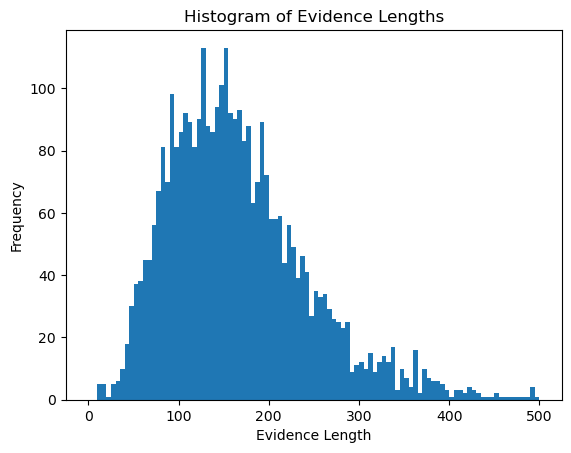

Number of bad documents: 83760


In [5]:
claim_evidence_list = [claim['evidences'] for claim in train_data.values()]
claim_evidence_list = claim_evidence_list + [claim['evidences'] for claim in val_data.values()]
claim_evidence_list = list(set([evidence for evidence_list in claim_evidence_list for evidence in evidence_list]))
evidence_lengths = [len(document_store[ev]) for ev in claim_evidence_list] 

plt.hist(evidence_lengths, bins=100, range=(0,500))
plt.xlabel('Evidence Length')
plt.ylabel('Frequency')

plt.title('Histogram of Evidence Lengths')
plt.show()

# we will define "bad" documents as ones that have less than 50 characters
bad_documents = []
for i, evidence_text in document_store.items():
    if len(evidence_text) < 50:
        bad_documents.append((i, evidence_text))

print(f"Number of bad documents: {len(bad_documents)}")        

#### Let's remove the bad passages (defined as any passage less than 50 characters long) from evidence list.

In [6]:
document_store_cleaned = {i: evidence_text for i, evidence_text in document_store.items() if len(evidence_text) >= 50}

#### Let's train a BM25 model on this cleaned document store. We're setting b to a small value (close to zero) for the BM25 because we don't want to penaliize longer passages.

#### We also use stopword removal and Porter stemming on documents and queries.

In [37]:
# instantiate and train a retirever 
retreiver = IR_System(k=1.5, b=0.1, remove_stopwords=True, apply_stemming=True)
passages = list(document_store_cleaned.values()) 
retreiver.train(passages)   

Computing TFIDF...


100%|██████████| 1125067/1125067 [02:05<00:00, 8935.52it/s]


#### Now let's run some tests. First, we pick a few example training instances and compare the retreived passages with the ground truth evidence list. We also have to pick a value for the top-k parameter for the retreiver, we'll use k=5 for now.

In [12]:
passage_ids = list(document_store_cleaned.keys())
train_claims = list(train_data.values())

In [ ]:
example_claim = train_claims[450]
query = example_claim["claim_text"]
gold_evidence_list = example_claim["evidences"]
print(f"Query: {query}")
print(f"Label: {example_claim['claim_label']}")
print(f"\nGold evidence list:")
for evidence_id in gold_evidence_list:
    print(f"{evidence_id}: {document_store_cleaned[evidence_id]}")

# retrieve relevant evidence passages
print("")
topk_doc_indices, best_scores = retreiver.retrieve_docs(query, topk=5)
topk_evidence_ids = [passage_ids[idx] for idx in topk_doc_indices]
for i, evidence_id in enumerate(topk_evidence_ids):
    print(f"Score: {best_scores[i]}, {evidence_id}: {document_store_cleaned[evidence_id]}")

# evaluation (precision, recall, F1)
intersection = set(topk_evidence_ids).intersection(gold_evidence_list)
print(f"\nMatching evidence passages: {intersection}")
precision = len(intersection) / len(topk_evidence_ids)
recall = len(intersection) / len(gold_evidence_list)
f1 = (2*precision*recall/(precision + recall)) if (precision + recall) > 0 else 0 
print(f"\nPrecision: {precision}, Recall: {recall}, F1: {f1}")

Query: The EPA director under Obama said the Clean Power Initiative would have no effect on man-made CO2 emissions.
Label: REFUTES

Gold evidence list:
evidence-825299: In 2014, President Barack Obama proposed a series of Environmental Protection Agency (EPA) regulations, known as the Clean Power Plan that would reduce carbon pollution from coal-fired power plants.
evidence-485241: In 2015, Obama also announced the Clean Power Plan, which is the final version of regulations originally proposed by the EPA the previous year, and which pertains to carbon dioxide emissions from power plants.
evidence-1175010: The Clean Power Plan was an Obama administration policy aimed at combating global warming that was first proposed in 2014.

Score: 1.2176929452967182, evidence-485241: In 2015, Obama also announced the Clean Power Plan, which is the final version of regulations originally proposed by the EPA the previous year, and which pertains to carbon dioxide emissions from power plants.
Score: 1.

In [ ]:
example_claim = train_claims[983]
query = example_claim["claim_text"]
gold_evidence_list = example_claim["evidences"]
print(f"Query: {query}")
print(f"Label: {example_claim['claim_label']}")
print(f"\nGold evidence list:")
for evidence_id in gold_evidence_list:
    print(f"{evidence_id}: {document_store_cleaned[evidence_id]}")

# retrieve relevant evidence passages
print("")
topk_doc_indices, best_scores = retreiver.retrieve_docs(query, topk=5)
topk_evidence_ids = [passage_ids[idx] for idx in topk_doc_indices]
for i, evidence_id in enumerate(topk_evidence_ids):
    print(f"Score: {best_scores[i]}, {evidence_id}: {document_store_cleaned[evidence_id]}")

# evaluation (precision, recall, F1)
intersection = set(topk_evidence_ids).intersection(gold_evidence_list)
print(f"\nMatching evidence passages: {intersection}")
precision = len(intersection) / len(topk_evidence_ids)
recall = len(intersection) / len(gold_evidence_list)
f1 = (2*precision*recall/(precision + recall)) if (precision + recall) > 0 else 0 
print(f"\nPrecision: {precision}, Recall: {recall}, F1: {f1}")

Query: While the Greenland interior is in mass balance, the coastlines are losing ice.
Label: SUPPORTS

Gold evidence list:
evidence-1010458: "Greenland's Coastal Ice Caps Have Melted Past The Point Of No Return".
evidence-55727: Methods agree that the Totten Glacier has lost ice in recent decades in response to ocean warming and possibly a reduction in local sea ice cover.

Score: 1.138751849921622, evidence-1134268: "Interannual variations of the mass balance of the Antarctica and Greenland ice sheets from GRACE".
Score: 1.0940919257619939, evidence-1200633: Land ice sheets in both Antarctica and Greenland have been losing mass since 2002 and have seen an acceleration of ice mass loss since 2009.
Score: 1.0334437624992143, evidence-947243: "Greenland Glaciers Losing Ice Much Faster, Study Says".
Score: 1.0328675348192762, evidence-44751: According to the study, in 1996 Greenland was losing about per year in volume from its ice sheet.
Score: 1.024798479267801, evidence-782976: "A Reco

In [ ]:
example_claim = train_claims[456]
query = example_claim["claim_text"]
gold_evidence_list = example_claim["evidences"]
print(f"Query: {query}")
print(f"Label: {example_claim['claim_label']}")
print(f"\nGold evidence list:")
for evidence_id in gold_evidence_list:
    print(f"{evidence_id}: {document_store_cleaned[evidence_id]}")

# retrieve relevant evidence passages
print("")
topk_doc_indices, best_scores = retreiver.retrieve_docs(query, topk=5)
topk_evidence_ids = [passage_ids[idx] for idx in topk_doc_indices]
for i, evidence_id in enumerate(topk_evidence_ids):
    print(f"Score: {best_scores[i]}, {evidence_id}: {document_store_cleaned[evidence_id]}")

# evaluation (precision, recall, F1)
intersection = set(topk_evidence_ids).intersection(gold_evidence_list)
print(f"\nMatching evidence passages: {intersection}")
precision = len(intersection) / len(topk_evidence_ids)
recall = len(intersection) / len(gold_evidence_list)
f1 = (2*precision*recall/(precision + recall)) if (precision + recall) > 0 else 0 
print(f"\nPrecision: {precision}, Recall: {recall}, F1: {f1}")

Query: Soares looks at short-term trends which are swamped by natural variations.
Label: NOT_ENOUGH_INFO

Gold evidence list:
evidence-1136019: Phenotypic variation (due to underlying heritable genetic variation) is a fundamental prerequisite for evolution by natural selection.
evidence-66602: Without phenotypic variation, there would be no evolution by natural selection.
evidence-1147924: It has been argued that this definition is a natural consequence of the effect of sexual reproduction on the dynamics of natural selection.
evidence-10820: He established the idea of a taxonomic hierarchy of classification based upon observable characteristics and intended to reflect natural relationships.
evidence-270997: Darwin argued that it was populations that evolved, not individuals, by natural selection from naturally occurring variation among individuals.

Score: 0.915807265978767, evidence-773024: Second, they describe only the long-term trends, because they are linked to orbital variations